<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/flower_photos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Rescaling,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

flower_photo/
  * daisy/
  * dandelion/
  * roses/
  * sunflowers/
  * tulips/








In [2]:
# download data
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 4s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

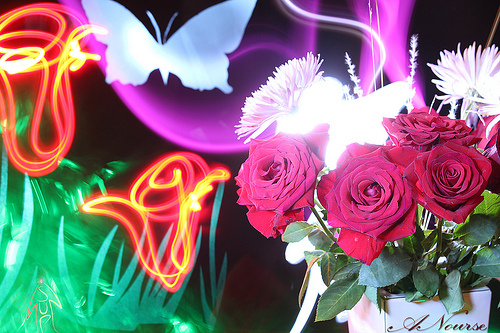

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[3]))

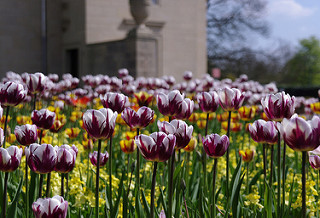

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

In [6]:
# Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory 
# utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a
# couple lines of code.

# define dome the parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=23>

In [10]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

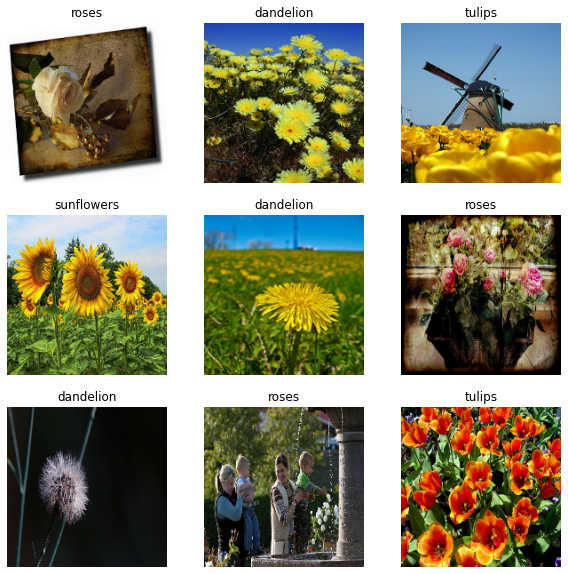

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
# Make sure to use buffered prefetching, so you can yield data from disk without having 
# I/O become blocking. These are two important methods you should use when loading data:
# 1. Dataset.cache  2. Dataset.prefetch 

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [63]:
num_classes = len(class_names)

def create_model():
  model = Sequential()
  
  # add data augmentation layers
  model.add(RandomFlip('horizontal',input_shape=(img_height,img_width,3)))
  model.add(RandomRotation(0.1))
  model.add(RandomZoom(0.1))

  # Normalize/standardize RGB channel values [0, 255] to a range in the [0, 1]
  model.add(Rescaling(1./255))

  # three convolution blocks with a max pooling layer in each of them
  model.add(Conv2D(16,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(32,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(64,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())

  # Add a layer of dropout layer
  model.add(Dropout(0.5))

  # flatten image for Dense layer
  model.add(Flatten())

  # fully-connected layer with 128 units on top of it that is activated by a ReLU 
  # activation function   
  model.add(Dense(128,activation='relu'))
  
  model.add(Dropout(0.5))
  model.add(Dense(128,activation='relu'))

  model.add(Dense(num_classes))


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model



In [33]:
def evaluate(model,epochs,fine_tunning=False,initial_epochs=0,
             prev_history=None):
  model.summary()
  history = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=epochs,
                      initial_epoch=initial_epochs)
  
  if prev_history is not None:
    acc = prev_history.history['accuracy'] + history.history['accuracy']
    val_acc = prev_history.history['val_accuracy'] + history.history['val_accuracy'] 

    loss = prev_history.history['loss'] + history.history['loss']
    val_loss = prev_history.history['val_loss'] + history.history['val_loss']

  elif prev_history is None:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
  

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')

  if fine_tunning:
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),
             label='Start fine tunning')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

  if fine_tunning:
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),
             label='Start fine tunning')
    
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  train_acc = history.history['accuracy'][-1]
  val_acc = history.history['val_accuracy'][-1]
  train_loss = history.history['loss'][-1]
  val_loss = history.history['val_loss'][-1]

  print(f'Training accuracy: {train_acc:.3f}\tTraining loss: {train_loss:.3f}')
  print(f'Validation accuracy: {val_acc:.3f}\tTraining loss: {val_loss:.3f}')

  return history


  


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                 

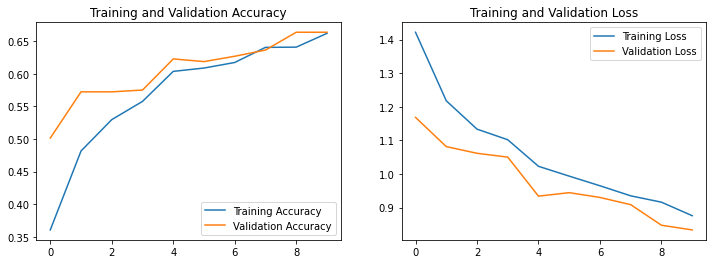

Training accuracy: 0.662	Training loss: 0.876
Validation accuracy: 0.663	Training loss: 0.834


In [64]:
model = create_model()
evaluate(model,10)

In [16]:
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

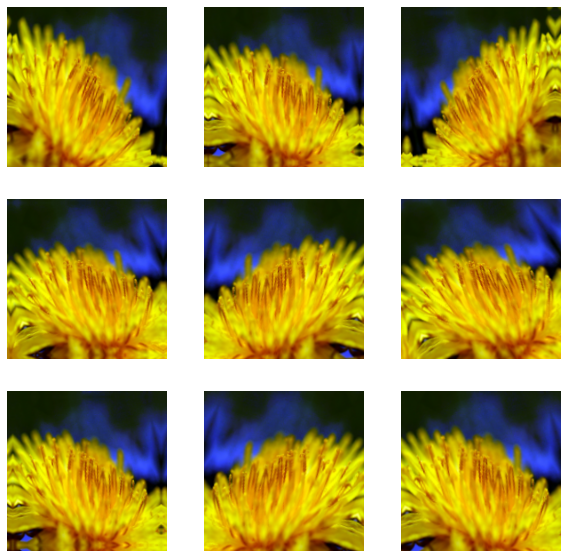

In [17]:
# Visualize a few augmented examples by applying data augmentation to the same 
# image several times:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_9 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_9 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                 

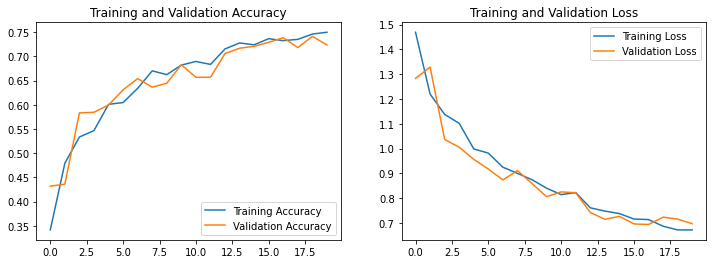

Training accuracy: 0.750	Training loss: 0.673
Validation accuracy: 0.723	Training loss: 0.698


In [65]:
model2 = create_model()
evaluate(model2,20)

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 178ms/step
This image most likely belongs to sunflowers with a 82.36 percent confidence.


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model2 = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model2)

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['random_flip_9_input'],
  'outputs': ['dense_27']}}

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(random_flip_9_input)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

NameError: ignored

In [ ]:
#=============================================================================
# feature extraction and transfer lerning

In [19]:
# Create the base model from the pre-trained model MobileNet V2
# This is pre-trained on the ImageNet dataset, a large dataset 
# consisting of 1.4M images and 1000 classes.
img_shape = (img_height,img_width,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
# Check how many layers base_model has
print(f'Base_model number of layers: {len(base_model.layers)}')

Base_model number of layers: 154


In [21]:
# use this for feature extraction and transfer learning using base_model, MobileNetV2
def train_base_model(trainable=False,fine_tune_at=None):

  # for feature extraction freeze the entire base_model
  if trainable == False:
    base_model.trainable = False
    print('Base_model layers are all frozed!')

  # for transfer learning train the top ~ 54 layers of base_model (and freeze the bottom 100 layers)
  # along with classifier layer
  if trainable:
    # unfreeze base_model for training
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

    print(f'Base_model is trainable above layer {fine_tune_at}!')

In [99]:
def create_model_v2():
   inputs = tf.keras.Input(shape=(180, 180, 3))
  
   # add image augmentation layers
   data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomFlip('horizontal'),
   tf.keras.layers.RandomRotation(0.2)])

   augmentation_layer = data_augmentation(inputs)

   # preprocess image for base_model
   processed_data = tf.keras.applications.mobilenet_v2.preprocess_input(augmentation_layer)

   # add base_model
   base_model_layer = base_model(processed_data,training=False)

   # average over the spatial 5x5 spatial locations, using a 
   # GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
   layer_a = GlobalAveragePooling2D()(base_model_layer)
   
   # Add a dropout layer
   layer_b = Dropout(0.2)(layer_a)

   # Add a classification layer: don't need an activation function here because this prediction 
   # will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, 
   # negative numbers predict class 0.
   outputs = Dense(5)(layer_b)

   model = keras.Model(inputs,outputs)
  
   return model

In [101]:
train_base_model()

Base_model layers are all frozed!


In [102]:
fe_tl_model = create_model_v2()

In [103]:
fe_tl_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
fe_tl_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

In [105]:
loss0,accuracy0 = fe_tl_model.evaluate(val_ds)

23/23 [==============================] - 2s 32ms/step - loss: 2.7854 - accuracy: 0.1689


In [106]:
print(f'Frozen base_model before classifier is trained')
print(f'Accuracy: {accuracy0:.3f}\t Loss: {loss0:.3f}')

Frozen base_model before classifier is trained
Accuracy: 0.169	 Loss: 2.785


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

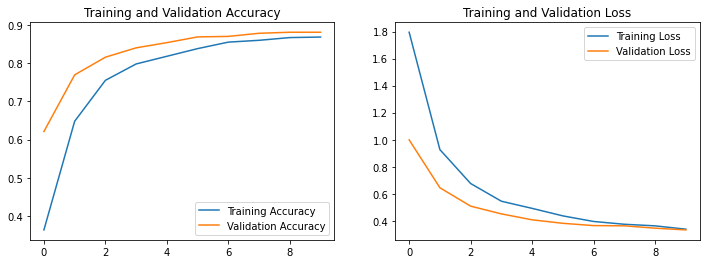

Training accuracy: 0.869	Training loss: 0.338
Validation accuracy: 0.881	Training loss: 0.333


In [107]:
# evaluate model with feature extraction
hsitory = evaluate(fe_tl_model,10)

In [108]:
# tune base_model layers above 100
train_base_model(True)

Base_model is trainable above layer 100!


In [109]:
fe_tl_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001/100),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

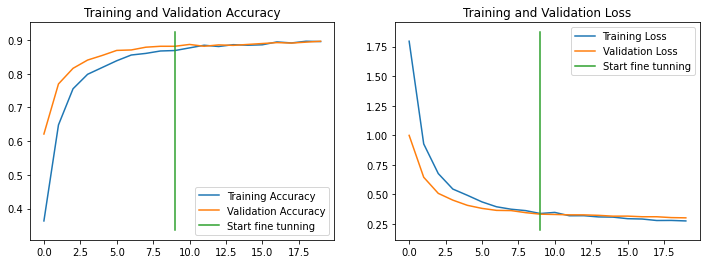

Training accuracy: 0.895	Training loss: 0.275
Validation accuracy: 0.896	Training loss: 0.302


In [110]:
# evaluate model with transfer learning where top ~54 layer of base_model get
# tuned to dataset
evaluate(fe_tl_model,20,True,10,hsitory)